In [25]:
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from statistics import mean
import random as rnd

sns.set()

The alpha-beta filter can be considered as a modification of the Kalman filter. Thus, this filter, like the Kalman filter, only works if the noises follow a normal distribution. However, in reality, noises often correspond to the Cauchy distribution, which is similar to the Gaussian distribution but has much heavier tails.

## Normal Distribution
The normal distribution (Gaussian distribution) has the following probability density function: \
$$
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$
<div style="text-align: left;">
$x$ - random variable <br>
$\mu$ - mean (average) <br>
$\sigma$ - standard deviation <br>
</div>

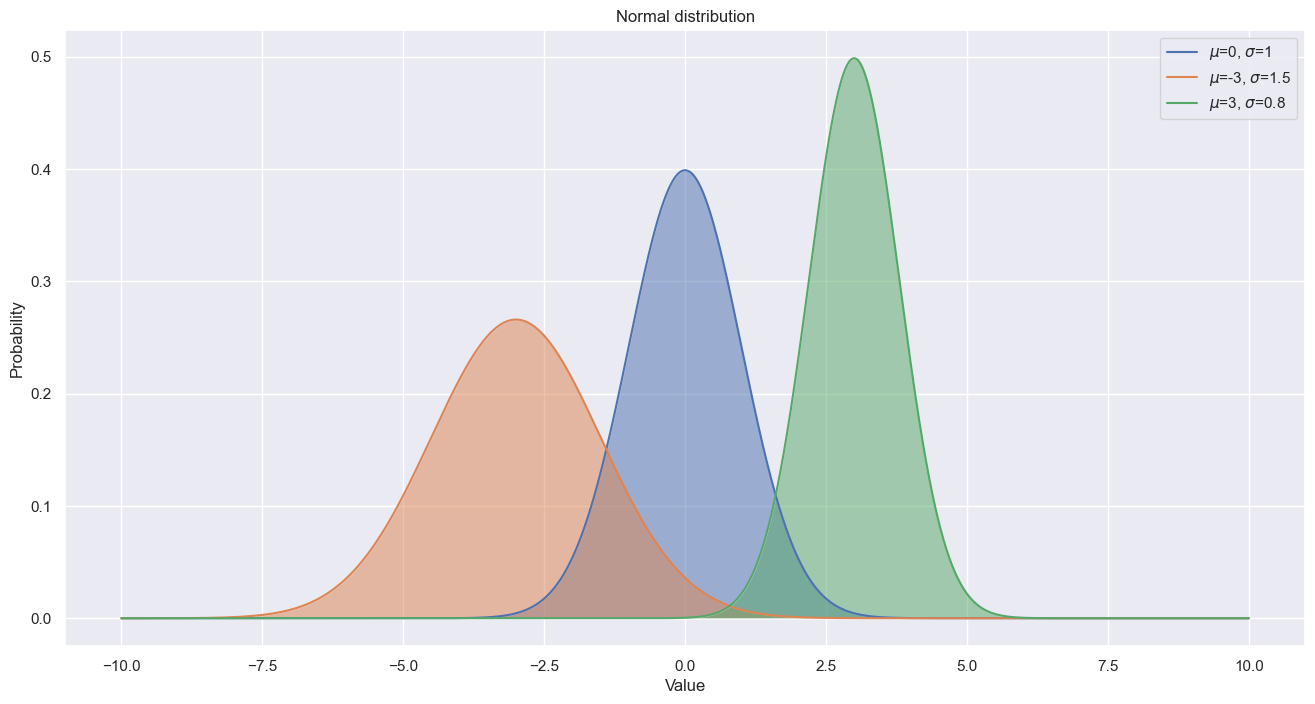

In [26]:
plt.figure(figsize=(16,8))
plt.title('Normal distribution')
plt.xlabel('Value')
plt.ylabel('Probability')


def plot_normal_distribution(mu, sigma, left, right, size):
    x = np.linspace(left, right, size)
    y = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2 / (2*sigma**2))
    label = '$\mu$=' + str(mu) + ', $\sigma$=' + str(sigma)
    plt.plot(x, y, label=label)
    plt.fill_between(x, 0, y, alpha=0.5)


plot_normal_distribution(mu=0, sigma=1, left=-10, right=+10, size=100000)
plot_normal_distribution(mu=-3, sigma=1.5, left=-10, right=+10, size=100000)
plot_normal_distribution(mu=3, sigma=0.8, left=-10, right=+10, size=100000)

plt.legend()
plt.show()

## Cauchy distribution
The Cauchy distribution has the following probability density function:
$$
f(x) = \frac{1}{\pi \gamma \left[ 1 + \left( \frac{x - x_0}{\gamma} \right)^2 \right]}
$$
where:
$x$ - random variable </br>
$x_0$ - median (position of the distribution peak) </br>
$\gamma$ - scale parameter (width of the distribution) </br>


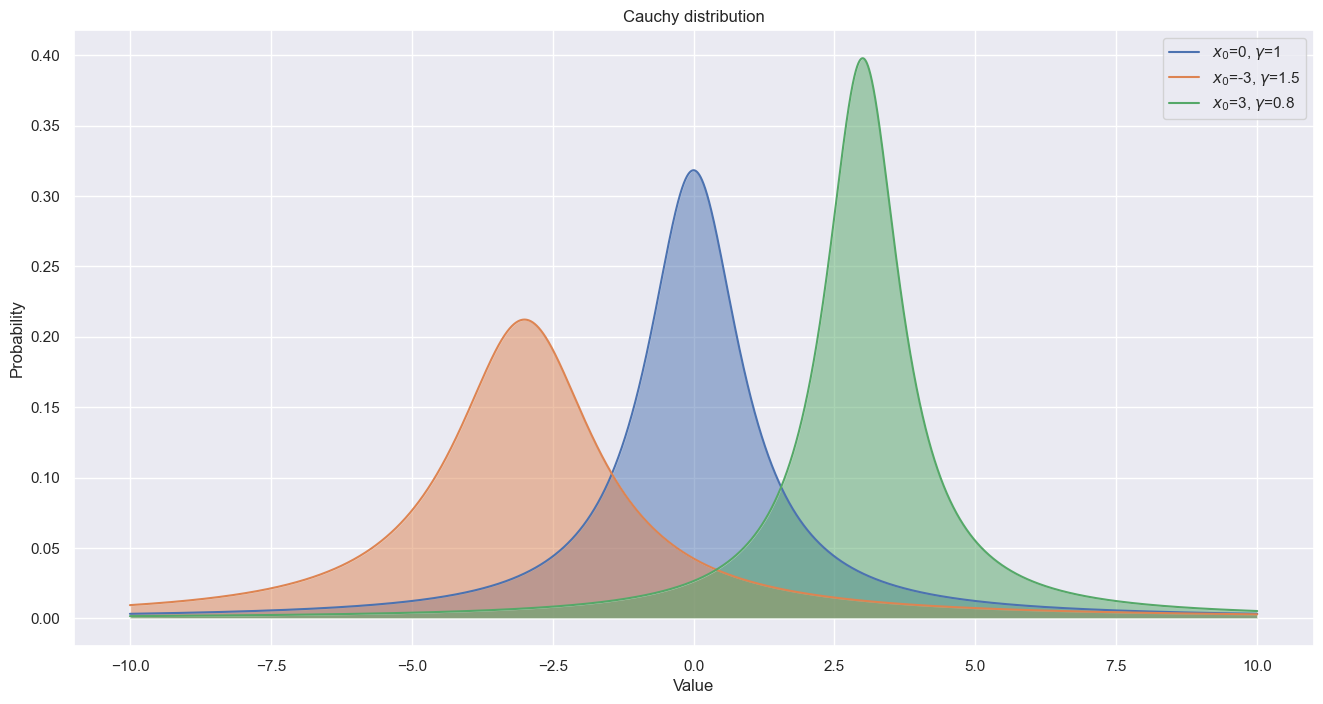

In [27]:
def plot_cauchy_distribution(x0, gamma, left, right, size):
    x = np.linspace(left, right, size)
    y = (1/(np.pi * gamma * (1 + ((x - x0)/gamma)**2)))
    label = '$x_0$=' + str(x0) + ', $\gamma$=' + str(gamma)
    plt.plot(x, y, label=label)
    plt.fill_between(x, 0, y, alpha=0.5)


plt.figure(figsize=(16,8))
plt.title('Cauchy distribution')
plt.xlabel('Value')
plt.ylabel('Probability')

plot_cauchy_distribution(x0=0,  gamma=1,  left=-10, right=+10, size=100000)
plot_cauchy_distribution(x0=-3, gamma=1.5, left=-10, right=+10, size=100000)
plot_cauchy_distribution(x0=3,  gamma=0.8, left=-10, right=+10, size=100000)

plt.legend()
plt.show()

## Comparison of filter performance

In [28]:
num_steps = 50
x0 = 0
gamma = 5.
cauchy_noise = sp.stats.cauchy.rvs(x0, gamma, num_steps)

In [29]:
x0 = 50.
V0 = 25.
dt = 1.
true = []

for i in range(num_steps):
    t = i * dt    
    true.append(x0 + (V0*t))

meas = true + cauchy_noise

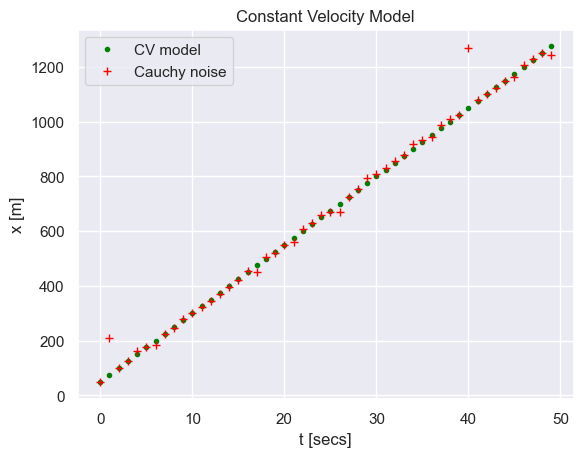

In [30]:
plt.title('Constant Velocity Model')
plt.xlabel('t [secs]')
plt.ylabel('x [m]')
plt.plot(true, marker='.', linestyle='none', color='green',  label='CV model')
plt.plot(meas, marker='+', linestyle='none', color='red',    label='Сauchy noise')
plt.legend(loc='upper left')
plt.show()

In [31]:
# This is the parameter that regulates the maximum confidence of the filter model
MAX_STEPS = 5


def filter_step(k, meas, dt, x_prev, V_prev):
    if (x_prev is None) and (V_prev is None): # first step of initialization
        k = k + 1
        return meas, None, k
    
    if V_prev is None:                        # second step of initialization
        k = k + 1
        return meas, (meas - x_prev) / dt, k
    
    a = 2.*(2. * k - 1.) / (k * (k + 1.))
    b = 6. / (k * (k + 1.))

    x_pred = x_prev + (V_prev*dt)
    V_pred = V_prev
    
    x = x_pred + (a * (meas - x_pred))
    V = V_pred + ((b / dt) * (meas - x_pred))
    
    if k < MAX_STEPS:
        k = k + 1
    
    return x, V, k

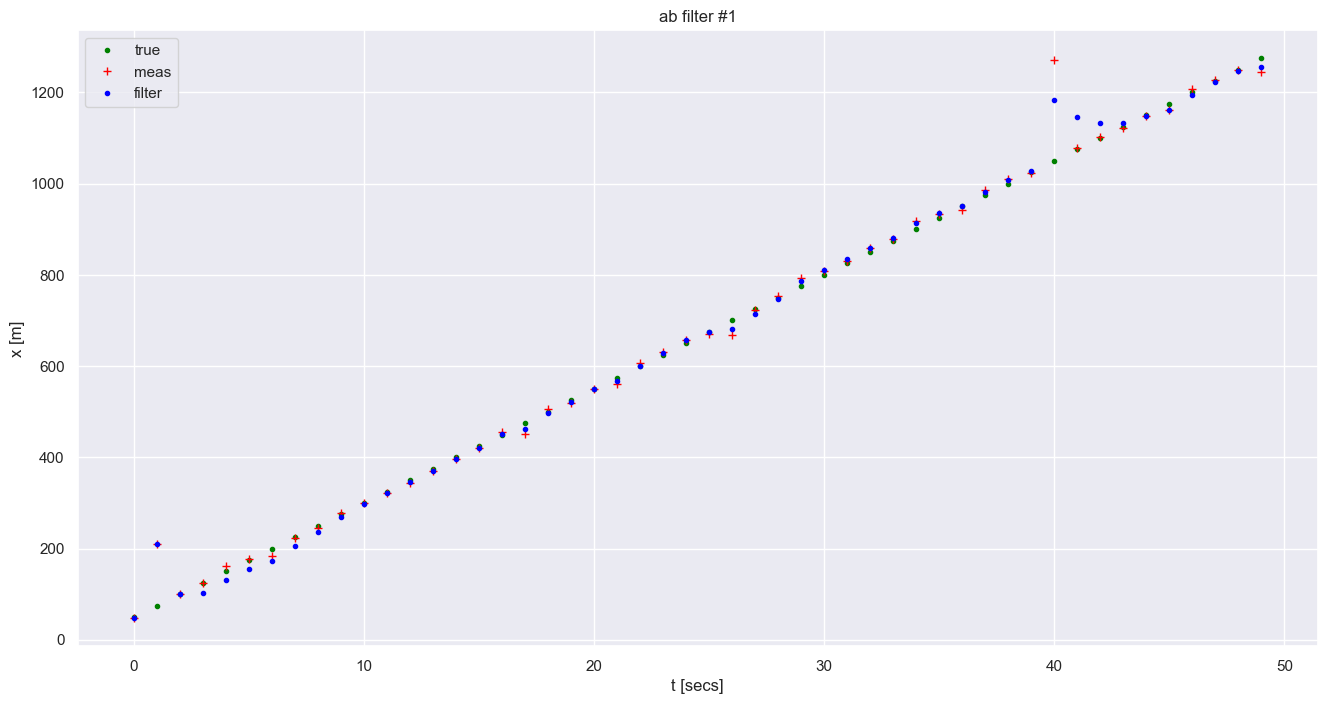

In [32]:
x_arr = []
V_arr = []
x_prev = None
V_prev = None
k = 0

for i in range(num_steps):
    x, V, k = filter_step(k, meas[i], dt, x_prev, V_prev)
    x_arr.append(x)
    V_arr.append(V)
    x_prev = x
    V_prev = V
    
plt.figure(figsize=(16,8))
plt.title('ab filter #1')
plt.xlabel('t [secs]')
plt.ylabel('x [m]')
plt.plot(true,  marker='.', linestyle='none', color='green', label='true'  ) 
plt.plot(meas,  marker='+', linestyle='none', color='red',   label='meas'  ) 
plt.plot(x_arr, marker='.', linestyle='none', color='blue',  label='filter')
plt.legend(loc='upper left')
plt.show()

In [33]:
class QueueToStandDev:
    def __init__(self, max_size):
        self.queue = []
        self.max_size = max_size
        self.sum_squares = 0        

    
    def enqueue(self, value):
        self.queue.append(value)
        self.sum_squares = self.sum_squares + (value ** 2)
        
        if len(self.queue) > self.max_size: 
            old_item = self.queue.pop(0)
            self.sum_squares = self.sum_squares - (old_item ** 2)
        
        return

    
    def get_standard_deviation(self):
        return np.sqrt(self.sum_squares / (len(self.queue) - 1.))

    
    def size(self):
        return len(self.queue)

In [34]:
# These are the parameters for eliminating measurement outliers
W_SIZE_TO_DETECT_OUTLIERS = 5
MAX_W_SIZE = 50

# this version of the filter takes emissions into account
def filter_step_2(k, meas, dt, x_prev, V_prev, w_arr):
    if (x_prev is None) and (V_prev is None): # first step of initialization
        k = k + 1
        return meas, None, k, w_arr
    
    if V_prev is None:                        # second step of initialization
        k = k + 1
        return meas, (meas - x_prev) / dt, k, w_arr

    x_pred = x_prev + (V_prev*dt)
    V_pred = V_prev
    w = meas - x_pred
    
    if (w_arr.size() > W_SIZE_TO_DETECT_OUTLIERS) and (abs(w) > (3. * w_arr.get_standard_deviation())):
        x = x_pred
        V = V_pred
        return x, V, k, w_arr

    a = 2.*(2. * k - 1.) / (k * (k + 1.))
    b = 6. / (k * (k + 1.))
    
    x = x_pred + (a * w)
    V = V_pred + ((b / dt) * w)
    
    if k < MAX_STEPS:
        k = k + 1
    
    if w_arr.size() < MAX_W_SIZE:
        w_arr.enqueue(abs(w))
        
    return x, V, k, w_arr

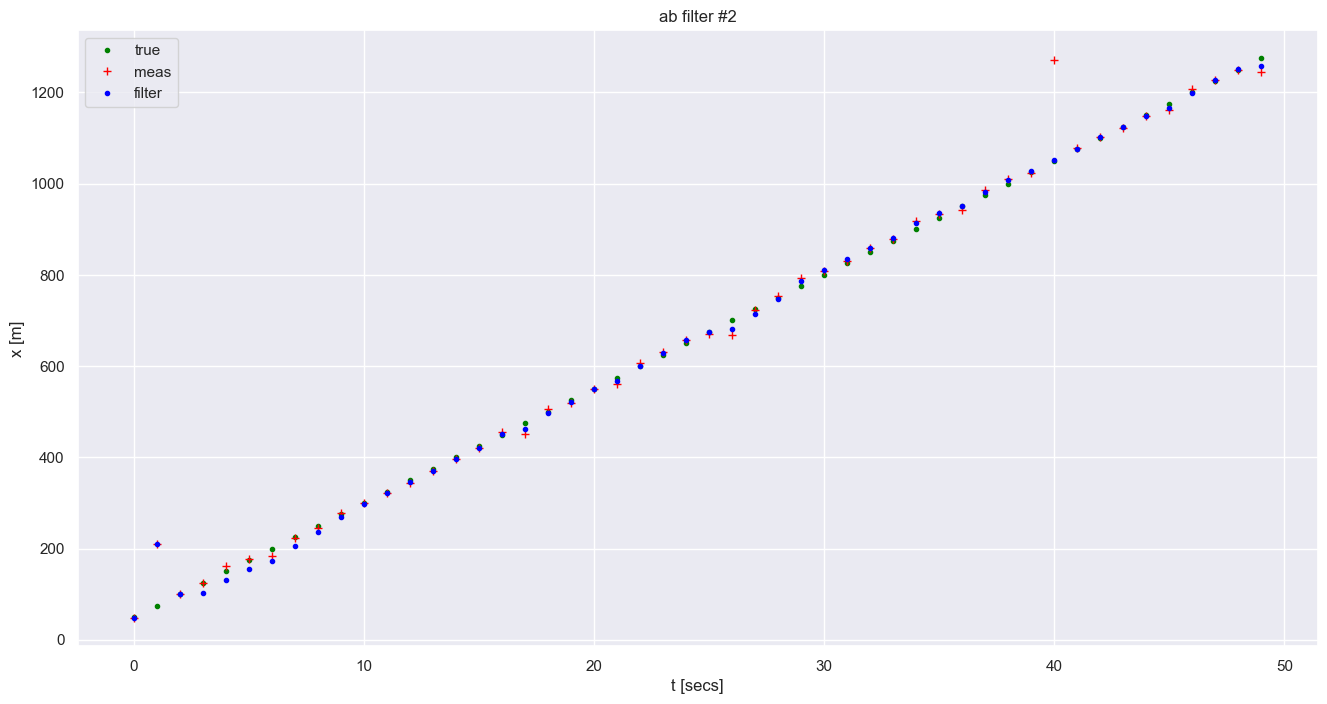

In [35]:
x_arr = []
V_arr = []
w_arr = QueueToStandDev(MAX_W_SIZE)
x_prev = None
V_prev = None
k = 0

for i in range(num_steps):
    x, V, k, w_arr = filter_step_2(k, meas[i], dt, x_prev, V_prev, w_arr)    
    x_arr.append(x)
    V_arr.append(V)
    x_prev = x
    V_prev = V
    
plt.figure(figsize=(16,8))
plt.title('ab filter #2')
plt.xlabel('t [secs]')
plt.ylabel('x [m]')
plt.plot(true,  marker='.', linestyle='none', color='green', label='true'  ) 
plt.plot(meas,  marker='+', linestyle='none', color='red',   label='meas'  ) 
plt.plot(x_arr, marker='.', linestyle='none', color='blue',  label='filter')
plt.legend(loc='upper left')
plt.show()

In [47]:
# These are the parameters for eliminating measurement outliers
MAX_NUMBER_OUTLIERS = 2

# this version of the filter takes into account outliers and possible inconsistency of the motion model
def filter_step_3(k, meas, dt, x_prev, V_prev, w_arr, num_outliers_in_row):
    if (x_prev is None) and (V_prev is None): # first step of initialization
        k = k + 1
        return meas, None, k, w_arr, 0
    
    if V_prev is None:                        # second step of initialization
        k = k + 1
        return meas, (meas - x_prev) / dt, k, w_arr, 0
    
    x_pred = x_prev + (V_prev*dt)
    V_pred = V_prev
    w = (meas - x_pred)
    
    if (w_arr.size() > W_SIZE_TO_DETECT_OUTLIERS) and (abs(w) > (3. * w_arr.get_standard_deviation())):
        x = x_pred
        V = V_pred
        num_outliers_in_row = num_outliers_in_row + 1
        if num_outliers_in_row <= MAX_NUMBER_OUTLIERS: 
            return x, V, k, w_arr, num_outliers_in_row
        else:
            k = 1
            return meas, None, k, w_arr, 0

    a = 2.*(2. * k - 1.) / (k * (k + 1.))
    b = 6. / (k * (k + 1.))
    
    x = x_pred + (a * w)
    V = V_pred + ((b / dt) * w)
    
    if k < MAX_STEPS:
        k = k + 1
    
    if w_arr.size() < MAX_W_SIZE:
        w_arr.enqueue(abs(w))
    
    return x, V, k, w_arr, 0

In [37]:
x0_new = 100.
V0_new = 50.

for i in range(num_steps):
    t = (num_steps + i) * dt
    true_coord = x0_new + (V0_new*t)
    true.append(true_coord)
    meas = np.append(meas, true_coord)

meas[num_steps:] += sp.stats.cauchy.rvs(0, gamma, num_steps)

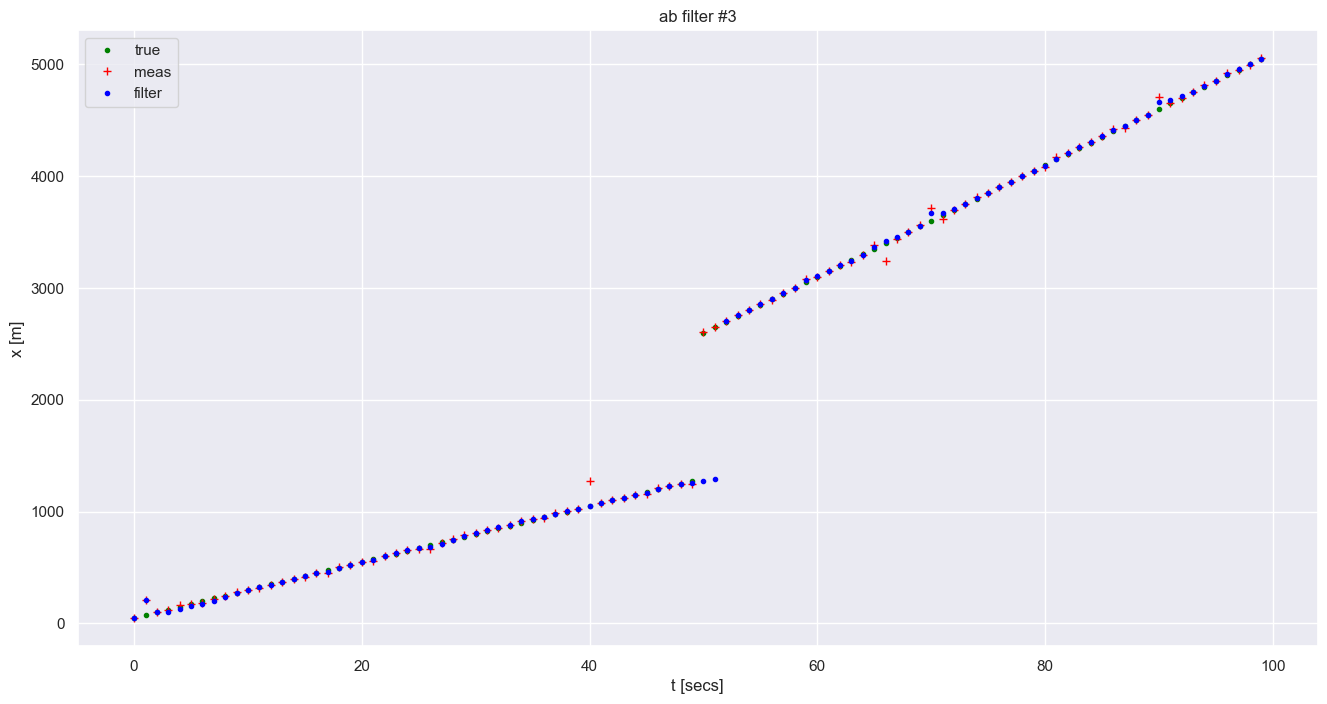

In [48]:
x_arr = []
V_arr = []
w_arr = QueueToStandDev(MAX_W_SIZE)
x_prev = None
V_prev = None
k = 0
num_outliers_in_row = 0

for i in range(len(meas)):
    x, V, k, w_arr, num_outliers_in_row = filter_step_3(k, meas[i], dt, x_prev, V_prev, w_arr, num_outliers_in_row)
    x_arr.append(x)
    V_arr.append(V)
    x_prev = x
    V_prev = V
    
plt.figure(figsize=(16,8))
plt.title('ab filter #3')
plt.xlabel('t [secs]')
plt.ylabel('x [m]')
plt.plot(true,  marker='.', linestyle='none', color='green', label='true'  ) 
plt.plot(meas,  marker='+', linestyle='none', color='red',   label='meas'  ) 
plt.plot(x_arr, marker='.', linestyle='none', color='blue',  label='filter')
plt.legend(loc='upper left')
plt.show()